# Guided Backpropagation

Guided backpropagation visualizes fine-grained details in the image. Its premise is: neurons act like detectors of particular image features, so when backpropagation, the gradient, negative gradients are set to zero to highlight the pixels that are important in the image.

In [ ]:
#importing libraries
import numpy as np

import cv2
import tensorflow as tf
import matplotlib.pyplot as plt
%matplotlib inline
import tensorflow.keras.backend as K
from skimage.transform import resize

import an image and the last layer for VGG19 convolution network

In [ ]:
# setting the image path
image = '/content/sample_data/cat.jpg'
# setting the last conv layer for VGG19
Layer = 'block5_conv4'

In [ ]:
# load image
img = tf.keras.preprocessing.image.load_img(image, target_size=(224, 224))

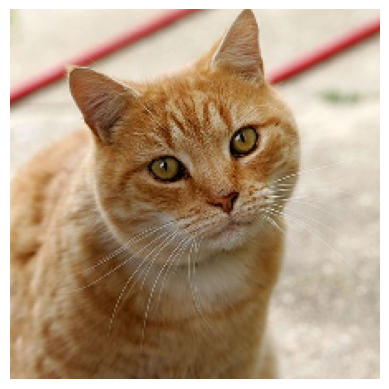

In [ ]:
# dysplaing image
plt.axis("off")
plt.imshow(img)
plt.show()

preprocess the image by using the VGG19’s preprocess function

In [ ]:
# converts PIL image to numpy array
img =  tf.keras.preprocessing.image.img_to_array(img)
# expanding the shape of the img array
x = np.expand_dims(img, axis=0)
# preprocess numpy array encoding to a batch of images
preprocessed_input = tf.keras.applications.vgg19.preprocess_input(x)

Importing the VGG19 transfered learning model on the imagenet dataset

In [ ]:
model = tf.keras.applications.vgg19.VGG19(weights='imagenet', include_top=True)

574710816/574710816 ━━━━━━━━━━━━━━━━━━━━ 6s 0us/step


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Define the save path inside Google Drive
model_path = "/content/drive/MyDrive/Models/vgg16_model.keras"

# Save the model
model.save(model_path)

We are creating a model until the last convolution layer from the imported VGG19 transferred learning model. When we use the fully connected layer in the deep learning CNN model, we lose the spatial information which is retained by convolution layers.

In [ ]:
gb_model = tf.keras.models.Model(
    inputs = [model.inputs],
    outputs = [model.get_layer(Layer).output]
)
layer_dict = [layer for layer in gb_model.layers[1:] if hasattr(layer,'activation')]

Gradients of ReLU are overridden by applying @tf.custom_gradient that allows the fine-grained control over the gradients for backpropagating non-negative gradients to have a more efficient or numerically stable gradient.

In [ ]:
@tf.custom_gradient
def guidedRelu(a):
  def grad(dy):
    return tf.cast(dy>0,"float32") * tf.cast(a>0, "float32") * dy
  return tf.nn.relu(a), grad

Applying the guided ReLU function to all the convolution layers wherever the activation function was ReLU

In [ ]:
for l in layer_dict:
  if l.activation == tf.keras.activations.relu:
    l.activation = guidedRelu

We will use the Gradient tape to record the processed input image during the forward pass and calculate the gradients for the backward pass. Basically it is used to capture the gradients of the final(last) convolution layer

In [ ]:
with tf.GradientTape() as tp:
  inputs = tf.cast(preprocessed_input, tf.float32)
  tp.watch(inputs)
  outputs = gb_model(inputs)[0]
grads = tp.gradient(outputs,inputs)[0]

/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: [['keras_tensor']]
Received: inputs=Tensor(shape=(1, 224, 224, 3))
  warnings.warn(msg)


Finally, visualizing the guided backpropagation

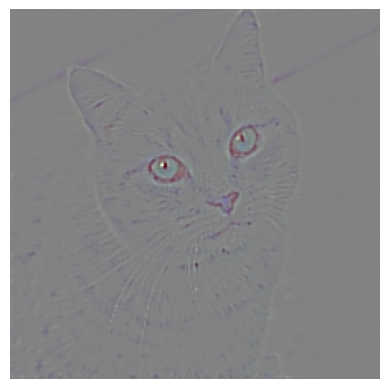

In [ ]:
#Visualizing the guided back prop
gb_prop = grads
guided_back_viz = np.dstack((
            gb_prop[:, :, 0],
            gb_prop[:, :, 1],
            gb_prop[:, :, 2],
        ))
guided_back_viz -= np.min(guided_back_viz)
guided_back_viz /= guided_back_viz.max()

imgplot = plt.imshow(guided_back_viz)
plt.axis("off")
plt.show()